In [11]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Calibration

**Author(s):**
 - Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

**Description:**

This notebook contains plots and benchmarks at calibration level (i.e. from _simtel_ to _DL0_).   

It currently follows the step-by-step comparison against _CTA-MARS_ , but:

- it can be extended to other pipelines,
- it can be applied to all cameras from Prod3b.

The documentation shows only input data and actual results for immediate display.  
You can find the details by opening the notebook from the _benchmarks_ folder in _protopipe_.  

**NOTE** [This](https://www.overleaf.com/16933164ghbhvjtchknf) document is supposed to be the official one regarding benchmarks, so we can use this notebook to add and/or propose modifications.

**Requirements:**

Due to recent code migration from _protopipe_ to _ctapipe_, to run this notebook you will need one or more HDF5 files produced with *ctapipe-stage1-process* (depending on the image extractor of your choice - if it doesn't require a 2nd pass, you'll have to comment-out those lines!).

You will find the relevant configuration files together with this notebook.

<ins>Comparison between protopipe and CTA-MARS</ins>
- simtel file to be used _gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz_  
- protopipe_CTAMARS_1stPass_calibration.json
- protopipe_CTAMARS_2ndPass_calibration.json
- reference production [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample).

**Development and testing:**  

All Prod3b cameras will be read by the notebook, but some of them are not optimized yet in _ctapipe_ (e.g. FlashCam).  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request, in order to check that the performance didn't decrease.

**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings). 

**TODO:**

* calibScale is applied only here, not in ctapipe
* ...


## Table of contents

* [Input data](#Input-data)
    - [Requirements](#Requirements)
        + [B-TEL-1010 "Intensity Resolution"](#B-TEL-1010-"Intensity-Resolution")
    - [MonteCarlo data](#MonteCarlo-data)
    - [Protopipe](#Protopipe)
    - [CTA-MARS](#CTA-MARS)
* [Plots and benchmarks](#Plots-and-benchmarks)
    - [R1-level information](#R1-level-information)
        + [Pedestals](#Pedestals)
        + [DC to PHE](#DC-to-PHE)
    - [Correlation between the reconstructed and true number of photoelectrons](#Correlation-between-the-reconstructed-and-true-number-of-photoelectrons)
    - [Charge resolution](#Charge-resolution)
    - [Calculation of the residual average bias](#Calculation-of-the-residual-average-bias)
    - [Charge resolution corrected for residual average bias](#Charge-resolution-corrected-for-residual-average-bias)
    - [RMS of charge resolution (around 1)](#RMS-of-charge-resolution-(around-1))
    - [Single-pixel spectra](#Single-pixel-spectra)
    - [Optimized cleaning thesholds](#Optimized-cleaning-thesholds)
        + [Method 1: 99.7% of "noise" rejection (obsolete)](#Method-1:-99.7%-of-"noise"-rejection)
        + [Method 2: fix relative frequency of charge (current standard)](#Method-2:-fix-relative-frequency-of-charge)

## Imports
[back to top](#Table-of-contents)

In [12]:
import os
from pathlib import Path

import numpy as np
from scipy.stats import percentileofscore
import tables
import uproot
from astropy.io import ascii
from astropy.table import Table, join

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from ctapipe.io import event_source
from ctapipe.io.astropy_helpers import h5_table_to_astropy as read_table
from ctapipe.instrument import CameraGeometry

## Functions
[back to top](#Table-of-contents)

### Add statistical information to a plot 
[back to top](#Table-of-contents)

In [13]:
def add_stats(data, ax, x = 0.70, y = 0.85, color = "black"):
    """Add a textbox containing statistical information."""
    mu = data.mean()
    median = np.median(data)
    sigma = data.std()
    textstr = '\n'.join((
        r'$\mu=%.4f$' % (mu, ),
        r'$\mathrm{median}=%.4f$' % (median, ),
        r'$\sigma=%.4f$' % (sigma, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(x, y, 
            textstr, 
            transform=ax.transAxes, 
            fontsize=10,
            horizontalalignment='left',
            verticalalignment='center', 
            bbox=props,
            color=color)

### Spectral weight from requirement B-TEL-1010 "Intensity Resolution"
[back to top](#0.-Table-of-contents)

In [14]:
def apply_weight_BTEL1010(data):
    """Define the weights from requirement B-TEL-1010-Intensity Resolution."""
    target_slope = -2.62 # this is the spectral slope as required by the B-TEL-1010 "Intensity Resolution" doc
    spec_slope = -2.0 # this is the spectral slope in the simtel files
    energies = data["true_energy"]*1.e3 # GeV
    # each pixel of the same image (row of data table) needs the same weight
    n_pixels = data["true_image"].shape[1]
    weights = np.repeat(np.power(energies/200., target_slope - spec_slope), n_pixels)
    return weights.ravel()

### Calculation of the residual bias
[back to top](#Table-of-contents)

In [15]:
def calc_bias(x_bin_edges, y_bin_edges, hist):
    """Calculate the average bias of charge resolution from 50 to 500 true photoeletrons.
    These limits are chosen in order to be safely away from saturation and from NSB noise.
    
    Parameters
    ----------
    x_bin_edges : 1D array
        Bin edges in true photoelectrons.
    y_bin_edges : 1D array
        Bin edges in reconstructed/true photoelectrons.
    hist : 2D array
        The full histogram of reconstructed/true against true photoelectrons.
        
    Returns
    -------
    bias : float
        Average bias of charge resolution from 50 to 500 true photoelectrons.
    
    """
    min_edge_index = np.digitize(1.7, x_bin_edges) - 1
    max_edge_index = np.digitize(2.7, x_bin_edges)

    proj = np.zeros(600)
    for i in range(min_edge_index, max_edge_index + 1):
        proj = proj + hist[i]

    y_bin_centers = 0.5*(y_bin_edges[1:] + y_bin_edges[:-1])

    bias = 1./np.average(y_bin_centers, weights = proj)
    
    return bias

### Root Mean Square around 1
[back to top](#Table-of-contents)

In [16]:
def calc_rms(values, weights):
    """Root Mean Square around 1 as proposed from comparison with CTA-MARS.
    
    The input values are vertical slices of the 2D histogram showing the bias-corrected charge resolution.
        
    Parameters
    ----------
    values : 1D array
        Values in reconstructed / true photoelectrons corrected for average bias.
    weights : 1D array
        Counts in a cell from the weigthed histogram.
    
    Returns
    -------
    rms : float
        Root Mean Square of around 1 for a vertical slice.
    
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    standard_deviation = np.sqrt(variance)
    a = np.power(standard_deviation,2)
    b = np.power(average-1,2)
    rms = np.sqrt(a+b)
    return rms

# missing errors (err_rms)

### Load data files or reset them if overwritten
[back to top](#Table-of-contents)

In [17]:
def load_reset_images(indir = "./", fileName = "images.h5", tel = "LST_LST_LSTCam"):
    """(Re)load the file containing the images and extract the data per telescope type.
    
    Parameters
    ----------
    
    indir : pathlib.Path
        Path of the folder containing the HDF5 file to be used.
    fileName : pathlib.Path
        Name the HDF5 file to be used.
    tel : str
        Complete identifier of the telescope+camera system to use.
    
    Returns
    -------
    
    true_images :
        Table containing basic information about the true images.
    reco_images :
        Table containing basic information about the reconstructed images.
    
    """
    
    filepath = Path(indir) / fileName
    
    with tables.open_file(filepath) as infile:
        true_images = read_table(infile, f"/simulation/event/telescope/images/{tel}")
        reco_images = read_table(infile, f"/dl1/event/telescope/images/{tel}")

    return true_images, reco_images

def load_reset_showers(indir = "./", fileName = "images.h5"):
    """(Re)load information regarding the simulated showers from the HDF5 file.
    
    Parameters
    ----------
    
    indir : str
        Path of the folder containing the HDF5 file to be used.
    fileName : str
        Name the HDF5 file to be used.
    
    Returns
    -------
    
    showers :
        Table containing basic information about the showers.
    
    """
    
    filepath = Path(indir) / fileName
    with tables.open_file(filepath) as infile:
        showers = read_table(infile, "/simulation/event/subarray/shower")
    
    return showers

## Input data
[back to top](#Table-of-contents)

In [18]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots_calibration").mkdir(parents=True, exist_ok=True)

All plots are stored in `./plots_calibration` with a suffix defined by the analysis name.

### Requirements
[back to top](#Table-of-contents)

#### B-TEL-1010 "Intensity Resolution"
[back to top](#Table-of-contents)

**Note:** converted in photolectrons, this requirement takes into account Poissonian fluctuations, which in turn are not taken into account in this version of the benchmarks.

In [19]:
photons = np.array([4.08996, 4.27598 , 4.47047 , 4.67381 , 4.88639 , 5.10864 , 5.341   , 5.58393 , 5.83791 , 6.10344 , 6.38105 , 6.67128 , 6.97472 , 7.29196 , 7.62362 , 7.97038 , 8.3329  , 8.71191 , 9.10816 , 9.52244 , 9.95555 , 10.4084 , 10.8818 , 11.3767 , 11.8942 , 12.4352 , 13.0008 , 13.5921 , 14.2103 , 14.8567 , 15.5324 , 16.2389 , 16.9775 , 17.7497 , 18.557  , 19.4011 , 20.2835 , 21.2061 , 22.1706 , 23.179  , 24.2333 , 25.3355 , 26.4879 , 27.6926 , 28.9522 , 30.2691 , 31.6458 , 33.0852 , 34.59   , 36.1633 , 37.8082 , 39.5278 , 41.3257 , 43.2054 , 45.1705 , 47.225  , 49.373  , 51.6187 , 53.9665 , 56.4211 , 58.9874 , 61.6704 , 64.4754 , 67.4079 , 70.4739 , 73.6793 , 77.0306 , 80.5342 , 84.1972 , 88.0268 , 92.0306 , 96.2166 , 100.593 , 105.168 , 109.952 , 114.953 , 120.181 , 125.648 , 131.362 , 137.337 , 143.584 , 150.115 , 156.943 , 164.081 , 171.544 , 179.346 , 187.504 , 196.032 , 204.948 , 214.27  , 224.016 , 234.205 , 244.858 , 255.995 , 267.639 , 279.812 , 292.539 , 305.844 , 319.755 , 334.299 , 349.504 , 365.401 , 382.021 , 399.397 , 417.563 , 436.555 , 456.412 , 477.171 , 498.875 , 521.565 , 545.288 , 570.09  , 596.02  , 623.129 , 651.472 , 681.103 , 712.082 , 744.47  , 778.332 , 813.733 , 850.745 , 889.44  , 929.896 , 972.191 , 1016.41 , 1062.64 , 1110.97 , 1161.5  , 1214.33 , 1269.57 , 1327.31 , 1387.68 , 1450.8  , 1516.79 , 1585.78 , 1657.9  , 1733.31 , 1812.15 , 1894.57 , 1980.75 , 2070.84 , 2165.03 , 2263.5  , 2366.46 , 2474.09 , 2586.62 , 2704.27 , 2827.27 , 2955.87 , 3090.31 , 3230.87 , 3377.82 , 3531.46 , 3692.09 , 3860.02 , 4035.58])
req = np.array([1.98387, 1.91316, 1.84541, 1.78049, 1.71827, 1.65863, 1.60145, 1.54663, 1.49407, 1.44366, 1.3953, 1.34892, 1.30441, 1.26169, 1.22069, 1.18133, 1.14354, 1.10725, 1.07238, 1.03889, 1.0067, 0.975761, 0.946017, 0.917414, 0.889904, 0.863438, 0.83797, 0.813457, 0.789858, 0.767131, 0.745241, 0.72415, 0.703825, 0.684233, 0.665342, 0.647122, 0.629546, 0.612586, 0.596217, 0.580413, 0.565152, 0.550412, 0.53617, 0.522407, 0.509103, 0.49624, 0.483801, 0.471769, 0.460128, 0.448862, 0.437958, 0.427401, 0.417179, 0.407278, 0.397688, 0.388395, 0.379391, 0.370664, 0.362204, 0.354003, 0.34605, 0.338337, 0.330857, 0.323601, 0.316561, 0.309732, 0.303104, 0.296673, 0.290432, 0.284375, 0.278496, 0.272789, 0.267249, 0.261872, 0.256651, 0.251584, 0.246664, 0.241888, 0.237252, 0.232751, 0.228382, 0.224141, 0.220025, 0.21603, 0.212152, 0.208389, 0.204737, 0.201193, 0.197755, 0.19442, 0.191185, 0.188047, 0.185003, 0.182052, 0.179191, 0.176417, 0.173729, 0.171124, 0.168599, 0.166153, 0.163784, 0.16149, 0.159268, 0.157117, 0.155035, 0.15302, 0.151071, 0.149185, 0.147361, 0.145597, 0.143892, 0.142244, 0.140651, 0.139112, 0.137625, 0.13619, 0.134804, 0.133465, 0.132174, 0.130928, 0.129726, 0.128566, 0.127448, 0.12637, 0.125331, 0.124329, 0.123364, 0.122435, 0.12154, 0.120678, 0.119848, 0.119049, 0.11828, 0.117541, 0.116829, 0.116145, 0.115487, 0.114854, 0.114245, 0.113661, 0.113099, 0.112559, 0.11204, 0.111542, 0.111063, 0.110604, 0.110162, 0.109739, 0.109332, 0.108942, 0.108567, 0.108208, 0.107863, 0.107532, 0.107215, 0.106911])

### MonteCarlo data
[back to top](#Table-of-contents)

**IMPORTANT Basic information about the reference simtel file**  
When referring to the comparison with CTA-MARS, the file used in these benchmarks is  
_gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz_  
and has the following basic features when NO selection is applied,
* number of simulated showers  = 9793
* number of images (LST + MST) = 44401
* min number of triggered telescopes per shower = 2

In [20]:
# load every time you want to plot simtel-related information....

indir = Path('/Users/michele/Applications/ctasoft/dirac/shared_folder/productions/Prod3b_NSB1x/LaPalma_20Zd/from_South/single_files') # path of the simtel file to be used
infile = 'gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz' # name of the simtel file to be used

with event_source(indir / infile) as source:

    camera_names = [camera_description.camera_name for camera_description in source.subarray.camera_types]
    print(f"This simtel file contains the following cameras : {camera_names}")

    # Find first event that triggeres all cameras

    for event in source:

        tels_with_data = event.r0.tels_with_data
        camera_names_triggered = [source.subarray.tels[tel].camera.camera_name for tel in tels_with_data]

        if all(camera_name in camera_names_triggered for camera_name in camera_names):
            print(f"Event #{event.count} is the first event which triggers all camera types and will be used for the simtel benchmarks.")
            break

    # Get minimum number of telescope to plot from
    tels_to_use = []
    for camera_name in camera_names:
        for tel in tels_with_data:
            if source.subarray.tels[tel].camera.camera_name == camera_name:
                tels_to_use.append(tel)
                break

    print(f"Telescopes that will be used for pedestals and dc_to_phe = {tels_to_use}")

This simtel file contains the following cameras : ['LSTCam', 'NectarCam']
Event #1 is the first event which triggers all camera types and will be used for the simtel benchmarks.
Telescopes that will be used for pedestals and dc_to_phe = [1, 6]


### Protopipe
[back to top](#Table-of-contents)

In [21]:
# Basic information
analysisName = "test" # a suffix for all the plots 
indir=Path('/Users/michele/Applications/ctasoft/tests/ctapipe/calibration') # path of the protopipe training files in your setup

fileName_1stPass='events_protopipe_CTAMARS_calibration_1stPass.dl1.h5' # protopipe training file with 2nd pass integration DISABLED
fileName_2ndPass='events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5' # protopipe training file with 2nd pass integration ENABLED

In [22]:
table = tables.open_file(indir / fileName_1stPass) # 1st or 2nd pass is the same here
all_mc_images = table.get_node("/simulation/event/telescope/images")
tel_types = [all_mc_images._f_list_nodes()[i].name for i in range(len(all_mc_images._f_list_nodes()))]
table.close()

print("The calibration benchmarks will be produced for the following telescope types:\n")
for tel_type in tel_types:
    print(f" - {tel_type}\n")

The calibration benchmarks will be produced for the following telescope types:

 - LST_LST_LSTCam

 - MST_MST_NectarCam



In [23]:
# Initialize empty dictionaries for camera-wise information
true_images = {}
reco1stPass = {}
reco2ndPass = {}

# Load subarray-wise information
showers = load_reset_showers(indir = indir, fileName = fileName_1stPass) # 1st or 2nd pass is the same here
showers = Table(showers[:])['event_id', 'true_energy']

# Load camera-wise information
for tel_type in tel_types:
    true, reco1 = load_reset_images(indir = indir, fileName = fileName_1stPass, tel = tel_type)
    _, reco2 = load_reset_images(indir = indir, fileName = fileName_2ndPass, tel = tel_type)
    
    true_images[tel_type] = true
    reco1stPass[tel_type] = reco1
    reco2ndPass[tel_type] = reco2

In [24]:
# Get one table per telescope type

data = {}

for tel_type in tel_types:
    
    # Convert to astropy tables, filtering out useless information
    true_images[tel_type] = Table(true_images[tel_type][:])['event_id','tel_id','true_image']
    reco1stPass[tel_type] = Table(reco1stPass[tel_type][:])['event_id','tel_id','image']
    reco2ndPass[tel_type] = Table(reco2ndPass[tel_type][:])['event_id','tel_id','image']
    
    images = join(true_images[tel_type], reco1stPass[tel_type], keys=['event_id', 'tel_id'], join_type='left')

    # merge each telescope type table of images with the shower information
    data[tel_type] = join(images, showers, keys=['event_id'], join_type='left')

In [25]:
# Check that all the images have been recorded
# WARNING: this works only on the specific simtel file used for these benchmarks! Please, use the same file.

missing_images = 44401
for tel_type in tel_types:
    missing_images -= len(data[tel_type])

if missing_images:
    
    print("NOTE: if you are NOT using the simtel file specific for the protopipe - CTA-MARS comparison, ignore the following warning.")
    
    print(f"WARNING: it appears you are missing {missing_images} images!")
    print(f"This corresponds to about {missing_images*100/44401:.0f}% of the total statistics.")
    print("Please, check that:")
    print("* either you have enabled some cuts in analysis.yaml,")
    print("* or you are not considering some events in your analysis when you write to file.")

In [26]:
# calibScale is placed here momentaneously
calibscale = 0.92

# initialize empty lists to store camera-wise information
true = {}
reco_1 = {}
reco_2 = {}
weights = {}

# cycle through recognized cameras and fill the required information
for tel_type in tel_types:
    
    true[tel_type] = data[tel_type]["true_image"].ravel()
    reco_1[tel_type] = data[tel_type]["image"].ravel() / calibscale
    reco_2[tel_type] = reco2ndPass[tel_type]["image"].ravel() / calibscale
    weights[tel_type] = apply_weight_BTEL1010(data[tel_type])

In [27]:
print(f"Total number of pixel-wise values read from simtel file and stored in DL1 files without cuts")
for tel_type in tel_types:
    print(f"{tel_type} = {len(true[tel_type])}")
print(f"'pixel-wise values' means #pixels * #cameras * #events")
print(f"In this phase all single-telescope images are considered.")

Total number of pixel-wise values read from simtel file and stored in DL1 files without cuts
LST_LST_LSTCam = 39381650
MST_MST_NectarCam = 42982205
'pixel-wise values' means #pixels * #cameras * #events
In this phase all single-telescope images are considered.


### CTA-MARS
[back to top](#Table-of-contents)

CTAMARS reference data is stored at [this URL](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki)

In [28]:
indir = Path("/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/CTAMARS_reference_data/DL1/")
fileName = "CTA_check_dl1a.root"
path_mars_hists = Path(indir/fileName)

fileName = "IntensityResolution_graphs.root"
path_mars_rms = Path(indir/fileName)

In [29]:
# from CTA_check_dl1a.root
file_hists = uproot.open(path_mars_hists)
hist2 = file_hists["hist2_type00"]
H2 = hist2.numpy()
# from IntensityResolution_graphs
file_rms = uproot.open(path_mars_rms)
rms = {}
rms["LST_LST_LSTCam"] = file_rms["IntensityResolution_LST"]
rms["MST_MST_NectarCam"] = file_rms["IntensityResolution_MST"]

## Plots and benchmarks
[back to top](#Table-of-contents)

### R1-level information
[back to top](#Table-of-contents)

#### Pedestals
[back to top](#Table-of-contents)

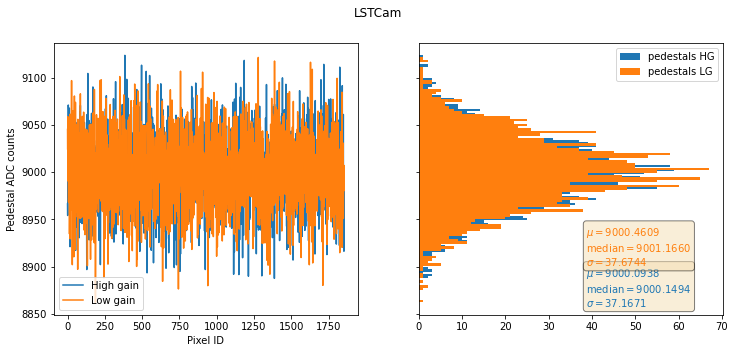

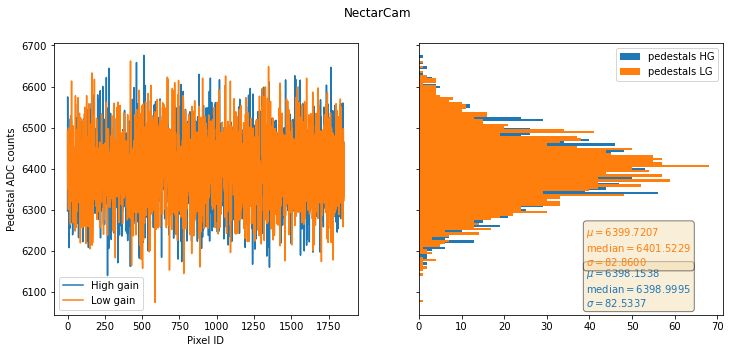

In [30]:
for tel_id in tels_to_use:

    cam_id = source.subarray.tel[tel_id].camera.camera_name
    pix_ids = source.subarray.tel[tel_id].camera.geometry.pix_id
    pedestals = event.mc.tel[tel_id].pedestal
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), tight_layout=False, sharey=True)
    plt.suptitle(cam_id)
    ax1.set_xlabel("Pixel ID")
    ax1.set_ylabel("Pedestal ADC counts")
    if len(pedestals)==2:
        p1 = ax1.plot(pix_ids, pedestals[1], label="High gain")
        p2 = ax1.plot(pix_ids, pedestals[0], label="Low gain")
        ax2.hist(pedestals[1], bins = 100, orientation="horizontal", label="pedestals HG")
        add_stats(pedestals[1], ax2, x = 0.55, y = 0.10, color = p1[0].get_color())
        ax2.hist(pedestals[0], bins = 100, orientation="horizontal", label="pedestals LG")
        add_stats(pedestals[0], ax2, x = 0.55, y = 0.25, color = p2[0].get_color())
        ax1.legend()
        ax2.legend()
    else:
        p1 = ax1.plot(pix_ids, pedestals[0])
        ax2.hist(pedestals[0], bins = 100, orientation="horizontal")
        add_stats(pedestals[0], ax2, x = 0.55, y = 0.10, color = p1[0].get_color())
    
    fig.savefig(f"./plots_calibration/pedestalsVSpixelids_{cam_id}_{analysisName}.png")

#### DC to PHE
[back to top](#Table-of-contents)

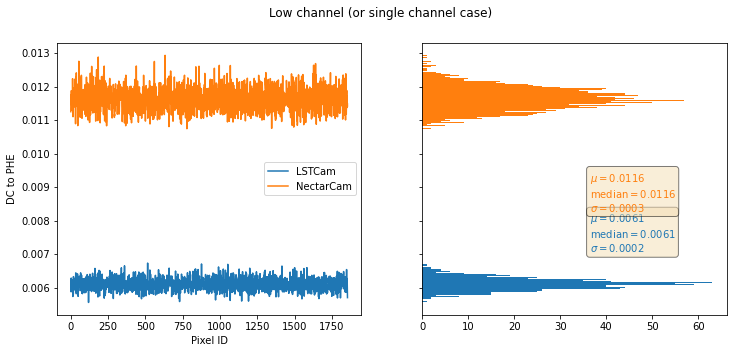

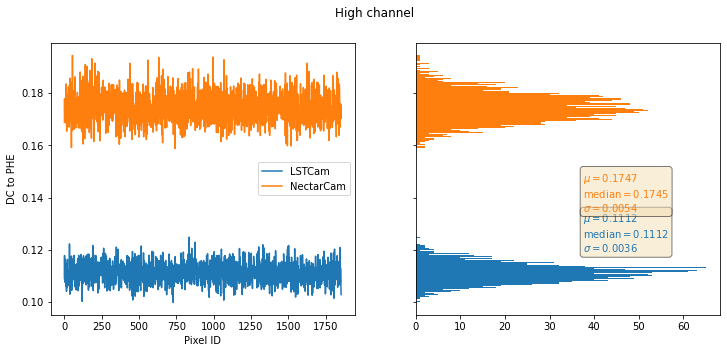

In [31]:
# plot channel-wise
for i, gain in enumerate(["Low", "High"]):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), tight_layout=False, sharey=True)
    title = f"{gain} channel" if gain == "High" else f"{gain} channel (or single channel case)"
    plt.suptitle(title)
    ax1.set_xlabel("Pixel ID")
    ax1.set_ylabel(f"DC to PHE")
    
    delta=0
    for tel_id in tels_to_use:
    
        cam_id = source.subarray.tel[tel_id].camera.camera_name
        pix_ids = source.subarray.tel[tel_id].camera.geometry.pix_id
        dc_to_pe = event.mc.tel[tel_id].dc_to_pe
        
        if len(dc_to_pe) == 1 and i==1:
            continue
        
        p = ax1.plot(pix_ids, dc_to_pe[i], label=cam_id)
        ax2.hist(dc_to_pe[i], bins = 100, orientation="horizontal")
        add_stats(dc_to_pe[i], ax2, x = 0.55, y = 0.30 + delta, color = p[0].get_color())
        delta+=0.15
        
    delta=0
        
    ax1.legend(loc="best")
    
    fig.savefig(f"./plots_calibration/dcTophe_{gain}Gain_VS_pixelids_{analysisName}.png")
    

### Correlation between the reconstructed and true number of photoelectrons
[back to top](#Table-of-contents)

In [32]:
mc = {} # true phes
reco = {} # reconstructed phes
w = {} # weigths from requirement B-TEL-1010
for tel_type in tel_types:
    # filter positive number of photoelectrons (because it's a log-log plot)
    good_values = np.where((true[tel_type]>0) & (reco_1[tel_type]>0))
    # combine cameras
    mc[tel_type] = true[tel_type][good_values]
    reco[tel_type] = reco_1[tel_type][good_values]
    # filter also weights
    w[tel_type] = weights[tel_type][good_values]

LST_LST_LSTCam
Total number of events in the plot of LST_LST_LSTCam (before re-weighting) = 1258881.0
MST_MST_NectarCam
Total number of events in the plot of MST_MST_NectarCam (before re-weighting) = 1417649.0


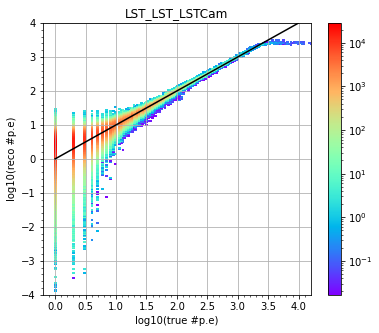

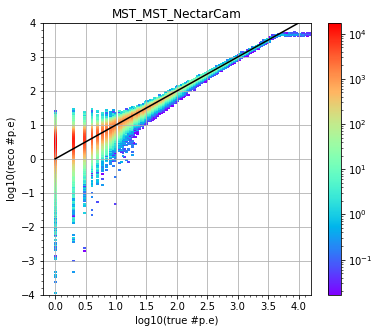

In [33]:
nbins_x = 400
nbins_y = 400

for tel_type in tel_types:
    print(tel_type)
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("log10(reco #p.e)")
    
    # This is just to count the real number of events given to the histogram
    h_no_weights = plt.hist2d(np.log10(mc[tel_type]), np.log10(reco[tel_type]),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,5.],[-7.,5.]],
                   norm=LogNorm(),
                  )
    
    # This histogram has the weights applied, so the number of events there is biased by this
    # This is what is plot
    h = plt.hist2d(np.log10(mc[tel_type]), np.log10(reco[tel_type]),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,5.],[-7.,5.]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=w[tel_type],
                  )
    
    plt.plot([0, 4], [0, 4], color="black") # line showing perfect correlation
    plt.minorticks_on()
    plt.xticks(ticks=np.arange(-1, 5, 0.5), labels=["",""]+[str(i) for i in np.arange(0, 5, 0.5)])
    plt.xlim(-0.2,4.2)
    plt.ylim(-4.,4.)
    plt.colorbar(h[3], 
                 ax=plt.gca()
                )
    plt.grid()
    
    fig.savefig(f"./plots_calibration/recoPhesVsTruePhes_{tel_type}_protopipe_{analysisName}.png")
    
    # Print some debug/benchmarking information
    print(f"Total number of events in the plot of {tel_type} (before re-weighting) = {h_no_weights[0].sum()}")

### Charge resolution
[back to top](#Table-of-contents)

In [34]:
mc = {} # true phes
reco = {} # reconstructed phes
w = {} # weigths from requirement B-TEL-1010
for tel_type in tel_types:
    # filter positive number of photoelectrons (because it's a log-log plot)
    good_values = np.where((true[tel_type]>0))
    # combine cameras
    mc[tel_type] = true[tel_type][good_values]
    reco[tel_type] = reco_1[tel_type][good_values]
    # filter also weights
    w[tel_type] = weights[tel_type][good_values]

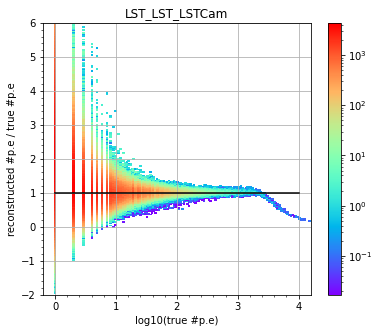

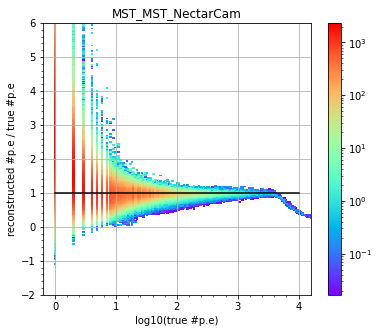

In [35]:
nbins_x = 800
nbins_y = 600

histogram = {} # camera-wise un-zoomes histogram for calculating bias later on

for tel_type in tel_types:
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("reconstructed #p.e / true #p.e")
    
    h = plt.hist2d(np.log10(mc[tel_type]), (reco[tel_type]/mc[tel_type]),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,15.],[-2,13]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=w[tel_type],
                  )
    
    histogram[tel_type] = h
    
    plt.plot([0, 4], [1, 1], color="black") # line showing perfect correlation
    plt.colorbar(h[3], ax=plt.gca()
                 #, format=ticker.FuncFormatter(fmt)
                )
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor')
    plt.grid()
    plt.xlim(-0.2,4.2)
    plt.ylim(-2.,6.)

    fig.savefig(f"./plots_calibration/chargeResolution_1stPass_{tel_type}_protopipe_{analysisName}.png")

### Calculation of the residual average bias
[back to top](#Table-of-contents)

In [36]:
corr = {}
print(f"Correction factors for residual average bias : ")
for tel_type in tel_types:
    corr[tel_type] = calc_bias(histogram[tel_type][1], histogram[tel_type][2], histogram[tel_type][0])
    print(f"- {tel_type} = {corr[tel_type]:.2f}")

Correction factors for residual average bias : 
- LST_LST_LSTCam = 0.97
- MST_MST_NectarCam = 1.01


### Charge resolution corrected for residual average bias
[back to top](#Table-of-contents)

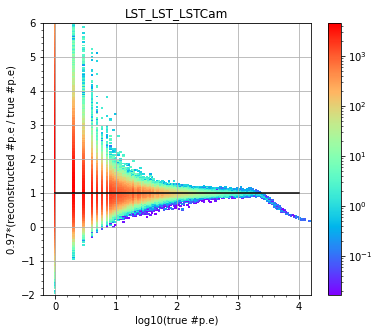

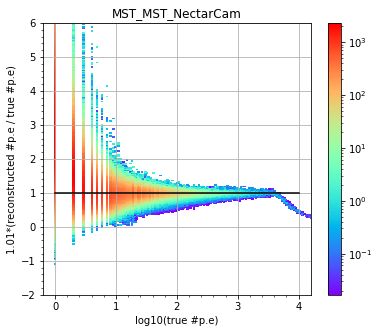

In [37]:
nbins_x = 800
nbins_y = 600

histogram = {} # camera-wise un-zoomes histogram for calculating RMS later on

for tel_type in tel_types:
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("{:.2f}*(reconstructed #p.e / true #p.e)".format(corr[tel_type]))
    
    h = plt.hist2d(np.log10(mc[tel_type]), corr[tel_type]*(reco[tel_type]/mc[tel_type]),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,15.],[-2,13]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=w[tel_type],
                  )
    
    histogram[tel_type] = h
    
    plt.plot([0, 4], [1, 1], color="black") # line showing perfect correlation
    plt.colorbar(h[3], ax=plt.gca())
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor')
    plt.grid()
    plt.xlim(-0.2,4.2)
    plt.ylim(-2.,6.)

    fig.savefig(f"./plots_calibration/chargeResolution_1stPass_{tel_type}_protopipe_{analysisName}.png")

### RMS of charge resolution (around 1)
[back to top](#Table-of-contents)

**WARNING:** the following comparison makes sense only if the provided simtel file is the one used in the comparison between *protopipe* and *CTA-MARS*. *protopipe* data from other cameras is anyway shown.

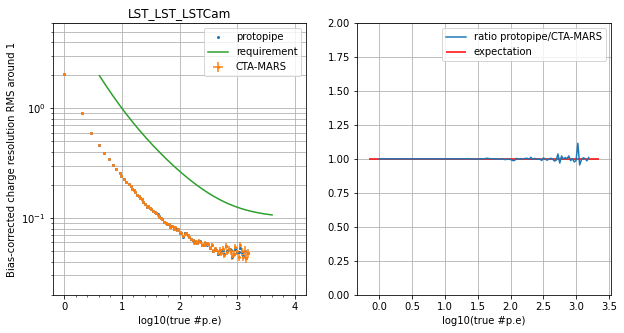

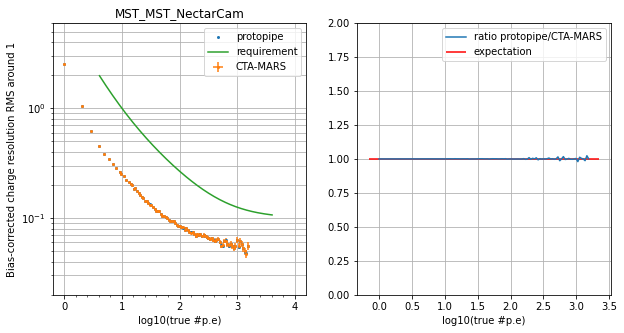

In [38]:
for tel_type in tel_types:
    
    fig = plt.figure(figsize=(10,5), tight_layout=False)
    
    plt.subplot(1,2,1)

    bin_edges_true = histogram[tel_type][1]
    bincenters_true = 0.5*(bin_edges_true[1:]+bin_edges_true[:-1]) # mean value of each bin in true photoelectrons
    bin_edges_y = histogram[tel_type][2] # bin edges in reconstructed photoelectrons
    bincenters_y = 0.5*(bin_edges_y[1:]+bin_edges_y[:-1]) # mean value of each bin in reconstructed photoelectrons

    # cycle over bins in true photoelectrons:
    values = []
    errors = []
    n = 0
    ref = []

    for true_bin in range(len(bincenters_true)):
        # if the bin center is over 3.2
        if (bincenters_true[true_bin] > 3.2):
            break # stop
        # if it's before -0.5
        if (bincenters_true[true_bin] < -0.5):
            continue # check the next bin
        # else proceed with the calculation
        # take the profile at this X bin along the Y axis
        profile_y = histogram[tel_type][0][true_bin] # this is the sequence of weights (aka the heights of the 600 bins)
        # if there is data falling in this X-axis bin,
        if np.sum(profile_y):
            ref.append(true_bin)
            # get the resolution the way Abelardo does
            # to do this we need also the bin centers along the Y axis
            result = calc_rms(bincenters_y, profile_y)
            values.append(result)

            # error bars TO DO

            n = n + 1
        else: # otherwise go to the next bin in true photoelectrons
            continue

    values = np.asarray(values)
    # errors = np.asarray(errors)

    # protopipe
    plt.plot(bincenters_true[ref], values, 'o', markersize=2, label="protopipe")
    # plt.errorbar(bincenters_true[ref], values, yerr=errors, fmt='o',markersize=2, label="protopipe")
    
    # CTA-MARS
    
    # only for LSTCam and NectarCam (comparison between pipelines)
    if tel_type == "LST_LST_LSTCam" or tel_type == "MST_MST_NectarCam":
        rms[tel_type].matplotlib(fmt="o", markersize=2, label="CTA-MARS")

    plt.yscale("log")
    plt.ylim(0.02,6)
    plt.xlim(-0.2,4.2)

    # superimose requirement converted in p.e. from abelardo script
    plt.plot(np.log10(photons), req, label="requirement")

    plt.grid(which='both', axis='y')
    plt.grid(which='major', axis='x')
    plt.minorticks_on()
    plt.legend()
    
    plt.title(tel_type)
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("Bias-corrected charge resolution RMS around 1")
    
    plt.subplot(1,2,2)
    
    # this is to prevent low statistics errors in other simtel files
    if tel_type == "LST_LST_LSTCam" or tel_type == "MST_MST_NectarCam" and (len(values) < len(rms[tel_type].yvalues)):
        values = np.append(values, np.repeat(np.nan, len(rms[tel_type].yvalues) - len(values)))
    
    # only for LSTCam and NectarCam (comparison between pipelines)
    if tel_type == "LST_LST_LSTCam" or tel_type == "MST_MST_NectarCam":
        plt.plot(rms[tel_type].xvalues, values/rms[tel_type].yvalues, label="ratio protopipe/CTA-MARS")
    ax = plt.gca()
    xlims=ax.get_xlim()
    plt.hlines(1., xlims[0], xlims[1], label="expectation", color='r')
    plt.ylim(0, 2)
    plt.grid()
    plt.legend()
    plt.xlabel("log10(true #p.e)")

    plt.show()
    
    fig.savefig(f"./plots_calibration/chargeResolution_RMSaround1_1stPass_{tel_type}_protopipe_{analysisName}.png")

**Note:** the requirement is placed only for completness, but it's not directly comparable to the data - see the *Requirements* section.

### Single-pixel spectra
[back to top](#Table-of-contents)

In [39]:
reco_1stPass = {} # reconstructed phes from the 1st pass
reco_2ndPass = {} # reconstructed phes from the 2nd pass

for tel_type in tel_types:
    # filter positive number of photoelectrons (because it's a log-log plot)
    good_values_1stPass = np.where(reco_1[tel_type]>0)
    good_values_2ndPass = np.where(reco_2[tel_type]>0)
    # combine cameras
    reco_1stPass[tel_type] = reco_1[tel_type][good_values_1stPass]
    reco_2ndPass[tel_type] = reco_2[tel_type][good_values_2ndPass]

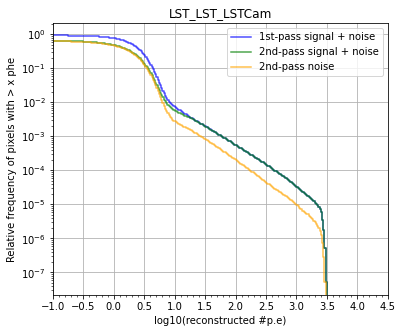

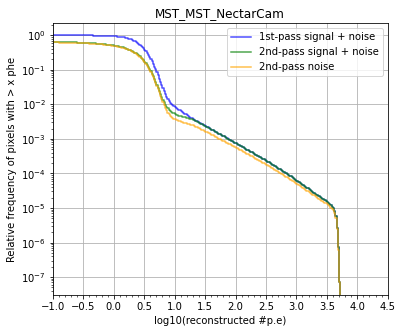

In [40]:
nbins = 250
xrange = [-1,4]

# dictionaries to store the spectra information for different methods
core_thresholds = {}
tot_entries = {}
noise_2ndPass = {}
signal_2ndPass = {}
hist_1 = {}
xbins_1 = {}
hist_2 = {}
xbins_2 = {}
hist_3 = {}
xbins_3 = {}
spectra = {}

for tel_type in tel_types:
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(reconstructed #p.e)")
    plt.ylabel("Relative frequency of pixels with > x phe")

    # all the original simulated events
    t = true[tel_type]
    tot_entries[tel_type] = len(t) # events * telescopes * pixels
    # 1st pass: no cut, all 1st pass images are saved by the image extractor TwoPassWindowSum
    # 2nd pass: only images which survived 1st pass and which preliminary image fit was non-patological
    # WARNING: no way to know in ctapipe 0.8
    t_2ndPass = t[np.where(reco_2[tel_type]>0)]
    
    # Since we are working only with simulated data,
    # "signal" is when a pixel has at least 1 simulated photoelectron
    # "noise"  is when a pixel has no simulated photoelectron
    signal_2ndPass[tel_type] = reco_2ndPass[tel_type][np.where(t_2ndPass>0)]
    noise_2ndPass[tel_type] = reco_2ndPass[tel_type][np.where(t_2ndPass==0)]
    # noise_2ndPass = reco_2[tel_types[i]][np.where(t==0)]
    # signal_2ndPass = reco_2[tel_types[i]][np.where(t>0)]
    
    # Plot 1st-Pass
    
    hist_1[tel_type], xbins_1[tel_type] = np.histogram(np.log10(reco_1stPass[tel_type]), bins=nbins, range=xrange)
    plt.semilogy(xbins_1[tel_type][:-1], hist_1[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="1st-pass signal + noise", color='blue')
    
    # Plot 2nd-Pass
    
    hist_2[tel_type], xbins_2[tel_type] = np.histogram(np.log10(reco_2ndPass[tel_type]), bins=nbins, range=xrange)
    spectra[tel_type] = plt.semilogy(xbins_2[tel_type][:-1], hist_2[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="2nd-pass signal + noise", color='green')

     # Plot 2nd-Pass noise
    
    hist_3[tel_type], xbins_3[tel_type] = np.histogram(np.log10(noise_2ndPass[tel_type]), bins=nbins, range=xrange)
    plt.semilogy(xbins_3[tel_type][:-1], hist_3[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="2nd-pass noise", color='orange')
    
    # common style options
    plt.xlim(xrange)
    plt.minorticks_on()
    plt.xticks(np.arange(min(xrange), max(xrange)+1, 0.5))
    plt.grid(which="major")
    plt.legend()
    
    fig.savefig(f"./plots_calibration/singlePixelSpectrum_{tel_types}_protopipe_{analysisName}.png")

### Optimized cleaning thesholds
[back to top](#Table-of-contents)

**WARNING:** since the pipeline doesn't know about the residual bias calculated before (at least for now), regardless of the method you choose, you need to use the BIASED units to setup the image cleaning (i.e. the values to be put in the analysis configuration file of protopipe).

**NOTE:** If the pipeline corrected perfectly everything, you would expect the bias to be almost 0, so in that case the final biased and unbiased values should be very similar.

#### Method 1: 99.7% of "noise" rejection
[back to top](#Table-of-contents)

**WARNING**:

The 99.7% cut we were using before seems to have been a fortuitous choice given by the fact that in protopipe 0.2.1-dev we were mimicking the CTA-MARS analysis almost at perfection.

In ctapipe 0.8.0 some changes have been introduced for which the *intrinsic* or *biased* spectra are now different.
Consequently, that cut is not reliable anymore (and indeed it gives way higher values - you can see it from the fact that the decoupling between "noise" and signal happens way before than where the line cut ends up).

For CTA-MARS the transistion happens at ~4 biased phe (0.6 in these plots)

LST_LST_LSTCam
Cutting at ~13.63396 biased photoelectrons rejects 99.7% of the noise and saves 90.2% of the signal
This corresponds to 13.22 **unbiased** photoelectrons.
Optimized image cleaning thresholds to be used in the analysis:
(core, boundary): (13.63, 6.82)--> (14, 7)

MST_MST_NectarCam
Cutting at ~26.47049 biased photoelectrons rejects 99.7% of the noise and saves 95.8% of the signal
This corresponds to 26.77 **unbiased** photoelectrons.
Optimized image cleaning thresholds to be used in the analysis:
(core, boundary): (26.47, 13.24)--> (26, 13)



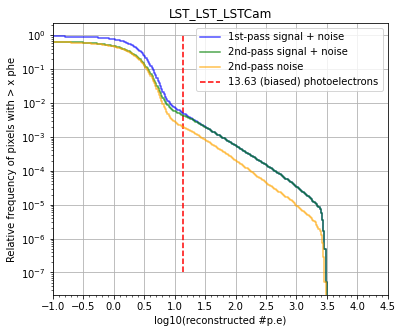

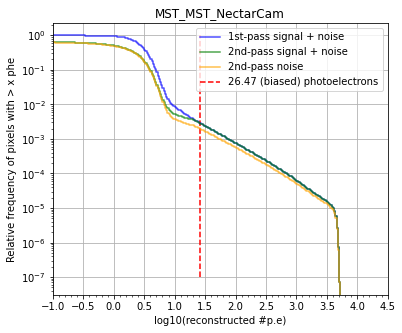

In [41]:
for tel_type in tel_types:
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(reconstructed #p.e)")
    plt.ylabel("Relative frequency of pixels with > x phe")
    
    # Plot 1st-Pass
    
    plt.semilogy(xbins_1[tel_type][:-1], hist_1[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="1st-pass signal + noise", color='blue')
    
    # Plot 2nd-Pass
    
    plt.semilogy(xbins_2[tel_type][:-1], hist_2[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="2nd-pass signal + noise", color='green')

    # Plot 2nd-Pass noise
    
    plt.semilogy(xbins_3[tel_type][:-1], hist_3[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="2nd-pass noise", color='orange')
    
    # common style options
    plt.xlim(xrange)
    plt.minorticks_on()
    plt.xticks(np.arange(min(xrange), max(xrange)+1, 0.5))
    plt.grid(which="major")
    plt.legend()
    
    # Find best cut
    cut = np.quantile(noise_2ndPass[tel_type], 0.997)
    core_thresholds[tel_type] = cut
    signal_saved = percentileofscore(signal_2ndPass[tel_type], cut)
    
    biased = core_thresholds[tel_type]
    unbiased = core_thresholds[tel_type] * corr[tel_type]
    
    # Update plot
    plt.vlines(np.log10(cut), ymin=1.e-7, ymax=1, color='red', linestyle="--", label=f"{cut:.2f} (biased) photoelectrons")
    plt.legend()
    
    # Print info about threshold cuts
    # This is information related to 2nd pass (the one that ends up into image cleaning)
    
    print(f"{tel_type}\n"
         "=================")
    
    print(f"Cutting at ~{cut:.5f} biased photoelectrons rejects 99.7% of the noise and saves {signal_saved:.1f}% of the signal")
    print(f"This corresponds to {unbiased:.2f} **unbiased** photoelectrons.")
    print(f"Optimized image cleaning thresholds to be used in the analysis:\n" 
          f"(core, boundary): ({biased:.2f}, {biased/2:.2f})"
          f"--> ({int(round(biased))}, {int(round(biased/2))})\n")
    
    fig.savefig(f"./plots_calibration/singlePixelSpectrum_{tel_types}_cleaningMethod1_protopipe_{analysisName}.png")

#### Method 2: fix relative frequency of charge
[back to top](#Table-of-contents)

The y-axis describes how often (relative to all events) a pixel has a signal above the charge value given by the x-axis.  
We fix a relative frequency of 1% to define the point at which noise is dominated by the shower's signal.

LST_LST_LSTCam
Transition from noise to signal happens at 7.24 reconstructed **biased** phe
This corresponds to 7.02 **unbiased** photoelectrons.
Optimized image cleaning thresholds to be used in the analysis:
(core, boundary): (7.24, 3.62)--> (7, 4)

MST_MST_NectarCam
Transition from noise to signal happens at 6.92 reconstructed **biased** phe
This corresponds to 7.00 **unbiased** photoelectrons.
Optimized image cleaning thresholds to be used in the analysis:
(core, boundary): (6.92, 3.46)--> (7, 3)



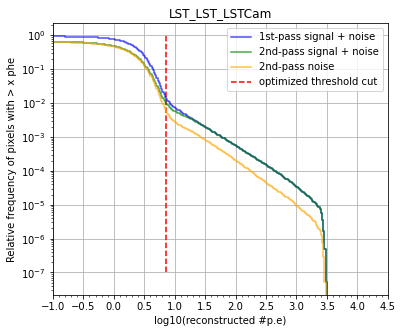

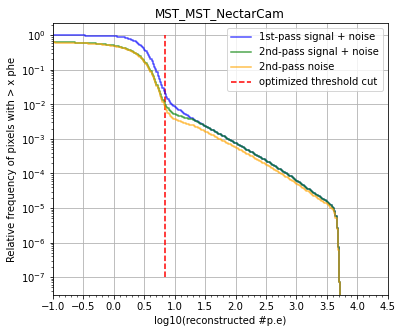

In [42]:
for tel_type in tel_types:
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(tel_type)
    plt.xlabel("log10(reconstructed #p.e)")
    plt.ylabel("Relative frequency of pixels with > x phe")
    
    # Plot 1st-Pass
    
    plt.semilogy(xbins_1[tel_type][:-1], hist_1[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="1st-pass signal + noise", color='blue')
    
    # Plot 2nd-Pass
    
    plt.semilogy(xbins_2[tel_type][:-1], hist_2[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="2nd-pass signal + noise", color='green')

    # Plot 2nd-Pass noise
    
    plt.semilogy(xbins_3[tel_type][:-1], hist_3[tel_type][::-1].cumsum()[::-1]/tot_entries[tel_type], drawstyle="steps-post",alpha=0.7, label="2nd-pass noise", color='orange')
    
    # common style options
    plt.xlim(xrange)
    plt.minorticks_on()
    plt.xticks(np.arange(min(xrange), max(xrange)+1, 0.5))
    plt.grid(which="major")
    plt.legend()
    
    # Find best cut
    
    x = spectra[tel_type][0].get_xdata()
    y = spectra[tel_type][0].get_ydata()
    
    y_t_idx = np.where(y<1.e-2)[0][0]
    x_t = x[y_t_idx]
    
    biased = 10**x_t
    unbiased = biased * corr[tel_type]
    
    # Update plot
    
    plt.vlines(x_t, ymin=1.e-7, ymax=1, color='red', linestyle="--", label=f"optimized threshold cut")
    plt.legend()
    
    # Print info about threshold cuts
    # This is information related to 2nd pass (the one that ends up into image cleaning)
    
    print(f"{tel_type}\n"
         "=================")
    print(f"Transition from noise to signal happens at {biased:.2f} reconstructed **biased** phe")
    print(f"This corresponds to {unbiased:.2f} **unbiased** photoelectrons.")
    print(f"Optimized image cleaning thresholds to be used in the analysis:\n" 
          f"(core, boundary): ({biased:.2f}, {biased/2:.2f})"
          f"--> ({int(round(biased))}, {int(round(biased/2))})\n")
    
    fig.savefig(f"./plots_calibration/singlePixelSpectrum_{tel_types[i]}_cleaningMethod2_protopipe_{analysisName}.png")
